In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


In [3]:
# -----------------------------
# 设备配置
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


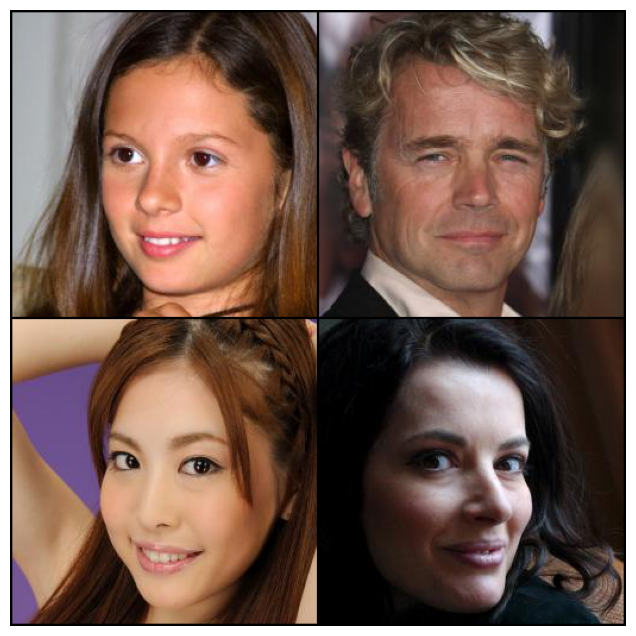

In [12]:
# -----------------------------
# 数据集 & DataLoader
# -----------------------------
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

# 图像预处理
transform = T.Compose([
    T.Resize((256, 256)),       # 调整到 256x256
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 映射到 [-1,1]
])

# 自定义 Dataset
class CelebAHQDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.files = glob.glob(root + "/*.jpg")  # 或 *.jpg
        if len(self.files) == 0:
            raise RuntimeError(f"No images found in {root}")
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

# 创建 Dataset 和 DataLoader
dataset = CelebAHQDataset(root="./CelebA-HQ/raw/data256x256", transform=transform)
dataloader = DataLoader(
    dataset,
    batch_size=4,      # HQ图像大，占显存，batch_size可调
    shuffle=True,
    num_workers=4,
    drop_last=True
)

# 可视化函数
def show_images(x, nrow=4):
    """
    x: tensor [B, C, H, W], 值在 [-1,1]
    nrow: 每行显示图片数量
    """
    x = (x + 1) / 2  # [-1,1] -> [0,1]
    grid = torchvision.utils.make_grid(x, nrow=nrow)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    plt.show()

# 测试显示
batch = next(iter(dataloader))
show_images(batch, nrow=2)


In [13]:
# -----------------------------
# DDPM 参数
# -----------------------------
T_steps = 1000
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T_steps)
alphas = 1. - betas
alpha_bars = torch.cumprod(alphas, dim=0)

def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    alpha_bar_t = alpha_bars.to(t.device)[t].view(-1, 1, 1, 1)
    return torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise

def timestep_embedding(timesteps, dim):
    half = dim // 2
    freqs = torch.exp(-np.log(10000) * torch.arange(half, device=timesteps.device) / half)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    return embedding

In [18]:
# -----------------------------
# UNet 模型定义
# -----------------------------
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.gn1 = nn.GroupNorm(8, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.gn2 = nn.GroupNorm(8, out_ch)
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.shortcut = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = F.relu(self.gn1(self.conv1(x)))
        t = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = h + t
        h = F.relu(self.gn2(self.conv2(h)) + self.shortcut(x))
        return h

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.block = ResBlock(in_ch, out_ch, time_emb_dim)
        self.pool = nn.AvgPool2d(2)
    def forward(self, x, t_emb):
        h = self.block(x, t_emb)
        return self.pool(h), h

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.block = ResBlock(in_ch, out_ch, time_emb_dim)
    def forward(self, x, skip, t_emb):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = torch.cat([x, skip], dim=1)
        x = self.block(x, t_emb)
        return x

class SimpleUNet(nn.Module):
    def __init__(self, time_emb_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(time_emb_dim, time_emb_dim), nn.ReLU())
        self.conv_in = nn.Conv2d(3, 64, 3, padding=1)
        # Downsample 层增加到4层
        self.down1 = Down(64, 64, time_emb_dim)    # 256->128
        self.down2 = Down(64, 128, time_emb_dim)   # 128->64
        self.down3 = Down(128, 256, time_emb_dim)  # 64->32
        self.down4 = Down(256, 512, time_emb_dim)  # 32->16
        self.bot = ResBlock(512, 512, time_emb_dim)
        # Upsample 对应调整
        self.up4 = Up(512+512, 512, time_emb_dim)
        self.up3 = Up(512+256,256, time_emb_dim)
        self.up2 = Up(256+128, 128, time_emb_dim)
        self.up1 = Up(128+64, 64, time_emb_dim)
        self.conv_out = nn.Conv2d(64, 3, 1)

    def forward(self, x, t):
        t_emb = timestep_embedding(t, 256)
        t_emb = self.time_mlp(t_emb)
        x = self.conv_in(x)
        x, skip1 = self.down1(x, t_emb)
        x, skip2 = self.down2(x, t_emb)
        x, skip3 = self.down3(x, t_emb)
        x, skip4 = self.down4(x, t_emb)
        x = self.bot(x, t_emb)
        x = self.up4(x, skip4, t_emb)
        x = self.up3(x, skip3, t_emb)
        x = self.up2(x, skip2, t_emb)
        x = self.up1(x, skip1, t_emb)
        return self.conv_out(x)

model = SimpleUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [15]:
# -----------------------------
# 采样函数
# -----------------------------
@torch.no_grad()
def p_sample(model, x_t, t):
    B, C, H, W = x_t.shape
    t_batch = torch.full((B,), t, device=x_t.device, dtype=torch.long)
    eps = model(x_t, t_batch)
    alpha_t = alphas[t]
    alpha_bar_t = alpha_bars[t]
    beta_t = betas[t]
    mean = (1/torch.sqrt(alpha_t))*(x_t - (1-alpha_t)/torch.sqrt(1-alpha_bar_t)*eps)
    if t > 0:
        z = torch.randn_like(x_t)
        x_prev = mean + torch.sqrt(beta_t)*z
    else:
        x_prev = mean
    return x_prev

@torch.no_grad()
def sample(model, shape=(4,3,256,256)):
    device = next(model.parameters()).device
    x_t = torch.randn(shape, device=device)
    for t in reversed(range(T_steps)):
        x_t = p_sample(model, x_t, t)
        if t % 200 == 0:
            print(f"sampling t={t}")
    return x_t

Step 500, loss: 0.0192
Step 1000, loss: 0.0038
Step 1500, loss: 0.0187
Step 2000, loss: 0.0014
Saved model at step 2000
sampling t=800
sampling t=600
sampling t=400
sampling t=200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sampling t=0


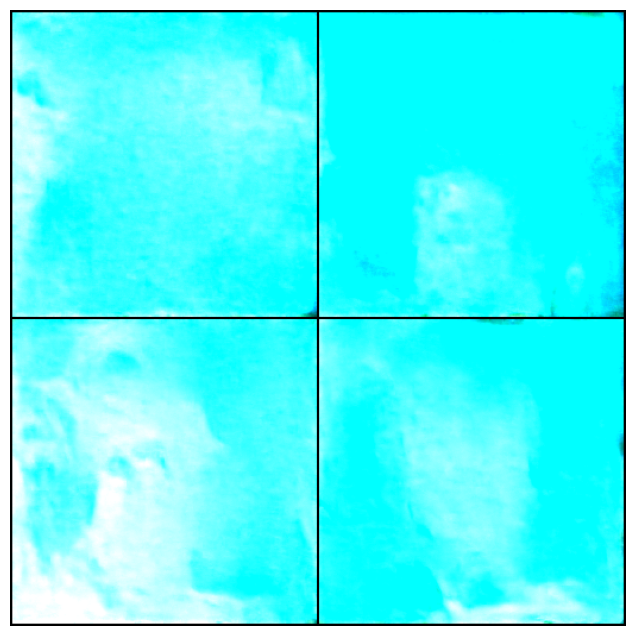

Step 2500, loss: 0.0060
Step 3000, loss: 0.0073
Step 3500, loss: 0.0132
Step 4000, loss: 0.0217
Saved model at step 4000
sampling t=800
sampling t=600
sampling t=400
sampling t=200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sampling t=0


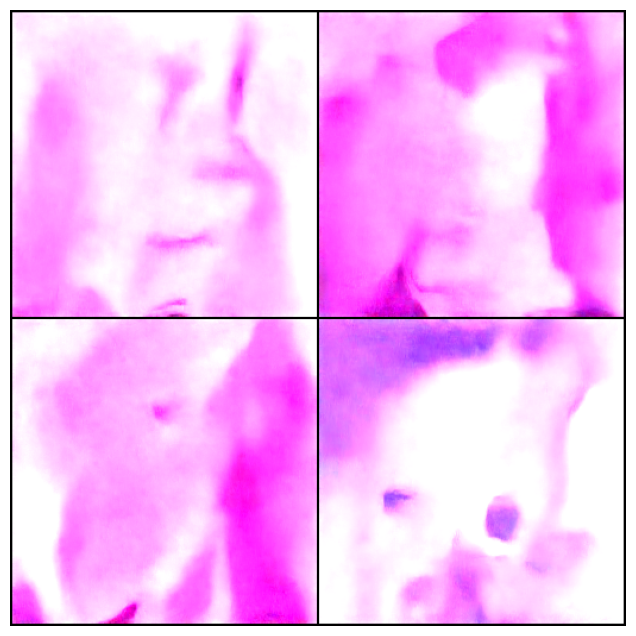

Step 4500, loss: 0.0136
Step 5000, loss: 0.0060
Step 5500, loss: 0.0052
Step 6000, loss: 0.0110
Saved model at step 6000
sampling t=800
sampling t=600
sampling t=400
sampling t=200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sampling t=0


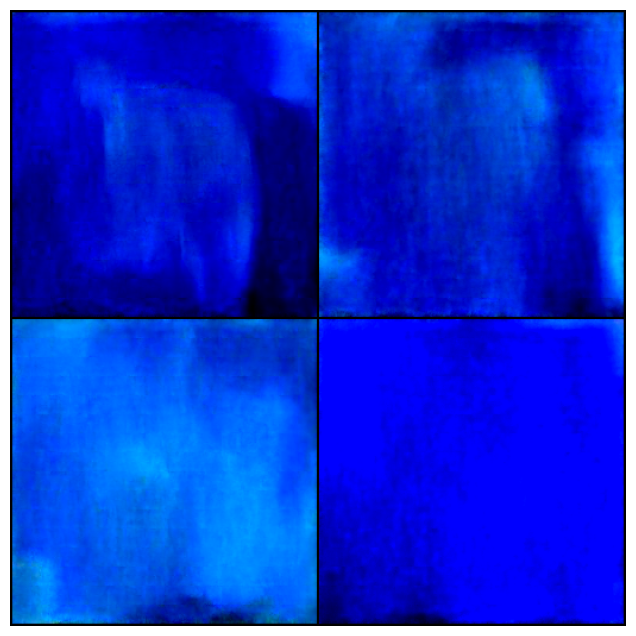

Step 6500, loss: 0.0017
Step 7000, loss: 0.0016
Step 7500, loss: 0.0013
Step 8000, loss: 0.0129
Saved model at step 8000
sampling t=800
sampling t=600
sampling t=400
sampling t=200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sampling t=0


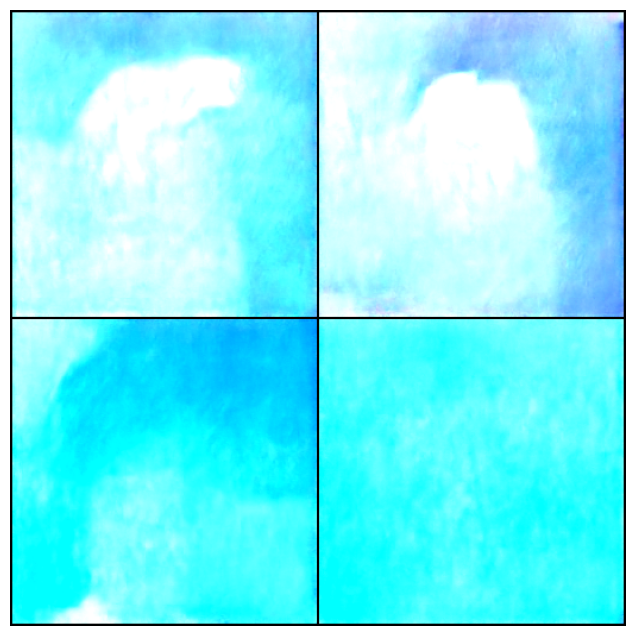

Step 8500, loss: 0.0209
Step 9000, loss: 0.0056
Step 9500, loss: 0.0009
Step 10000, loss: 0.0035
Saved model at step 10000
sampling t=800
sampling t=600
sampling t=400
sampling t=200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sampling t=0


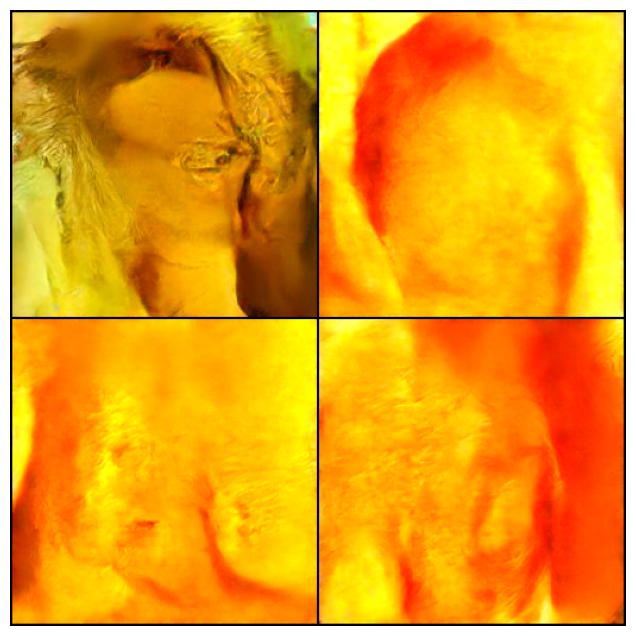

In [21]:
# -----------------------------
# 训练步骤
# -----------------------------
def train_step(x0):
    B = x0.size(0)
    t = torch.randint(0, T_steps, (B,), device=device)
    noise = torch.randn_like(x0)
    x_t = q_sample(x0, t, noise)
    noise_pred = model(x_t, t)
    loss = F.mse_loss(noise_pred, noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

# -----------------------------
# 训练循环
# -----------------------------
save_dir = "./checkpoints_celeb256"
os.makedirs(save_dir, exist_ok=True)

num_steps = 10000
log_interval = 500
save_interval = 2000
sample_interval = 2000

losses = []
model.train()
step_counter = 0

for epoch in range(1000):
    for x in dataloader:
        x = x.to(device)
        loss = train_step(x)
        losses.append(loss)
        step_counter += 1

        if step_counter % log_interval == 0:
            print(f"Step {step_counter}, loss: {loss:.4f}")

        if step_counter % save_interval == 0:
            torch.save(model.state_dict(), os.path.join(save_dir, f"ddpm_step{step_counter + 30000}.pt"))
            print(f"Saved model at step {step_counter}")

        if step_counter % sample_interval == 0:
            model.eval()
            x_gen = sample(model, (4,3,256,256))
            x_gen = (x_gen + 1)/2
            x_gen = x_gen.cpu()
            grid = torchvision.utils.make_grid(x_gen, nrow=2)
            plt.figure(figsize=(8,8))
            plt.imshow(grid.permute(1,2,0).numpy())
            plt.axis("off")
            plt.show()
            model.train()

        if step_counter >= num_steps:
            break
    if step_counter >= num_steps:
        break
